```
Copyright (c) Gradient Institute. All rights reserved.
Licensed under the Apache 2.0 License.
```


This notebook tests out the two stage ridge regression model again OLS and other ridge models for estimating treatment effects.



Hahn, P.R., Carvalho, C.M., Puelz, D., He, J., 2018. Regularization and Confounding in Linear Regression for Treatment Effect Estimation. Bayesian Anal. 13. https://doi.org/10.1214/16-BA1044

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import train_test_split

from twostageridge import TwoStageRidge, ridge_weights

np.random.seed(666)

%matplotlib inline

# Generate the data

In [2]:
data = load_boston()
X = data.data
N, _ = X.shape
D = 250
p_nzero = 0.1  # Only this proportion of the features are useful for predicting Z and Y
regulariser_range = (-2, 1)


# Standardise the controls
X -= X.mean(axis=0)
X /= X.std(axis=0)


# Make controls high dimensional
X = Nystroem(n_components=D).fit_transform(X)


# Generate a treatment column
epsilon = .25
beta_c = np.random.randn(D) * np.random.binomial(1, p_nzero, size=D)
Z = X @ beta_c + np.random.randn(N) * epsilon


# Generate the target
alpha = -0.5
nu = .3
beta_d = np.random.randn(D) * np.random.binomial(1, p_nzero, size=D)
Y = alpha * Z + X @ beta_d + np.random.randn(N) * nu


# Split this into training and testing data to get an idea of how the models overfit
W = np.hstack((Z[:, np.newaxis], X))
W, W_test, Y, Y_test = train_test_split(W, Y, test_size=0.33, shuffle=True)
N_train, N_test = len(Y), len(Y_test)


# "treatment" index, we need to give this to the two stage model.
treatment_ind = 0

# Ridge regression test

Regularisation on alpha and beta "out of the box"

$$\mathcal{L}_Y = \frac{1}{N} \sum^N_{i=1} \|Y_i - (\alpha Z_i + X_i \beta) \|^2_2 + \lambda \alpha^2 + \lambda \|\beta\|_2^2$$

And "confounded"

$$\mathcal{L}_Y = \frac{1}{N} \sum^N_{i=1} \|Y_i - (\alpha Z_i + X_i \beta) \|^2_2 + \lambda \|\beta\|_2^2$$

R^2 OLS = -123.3392


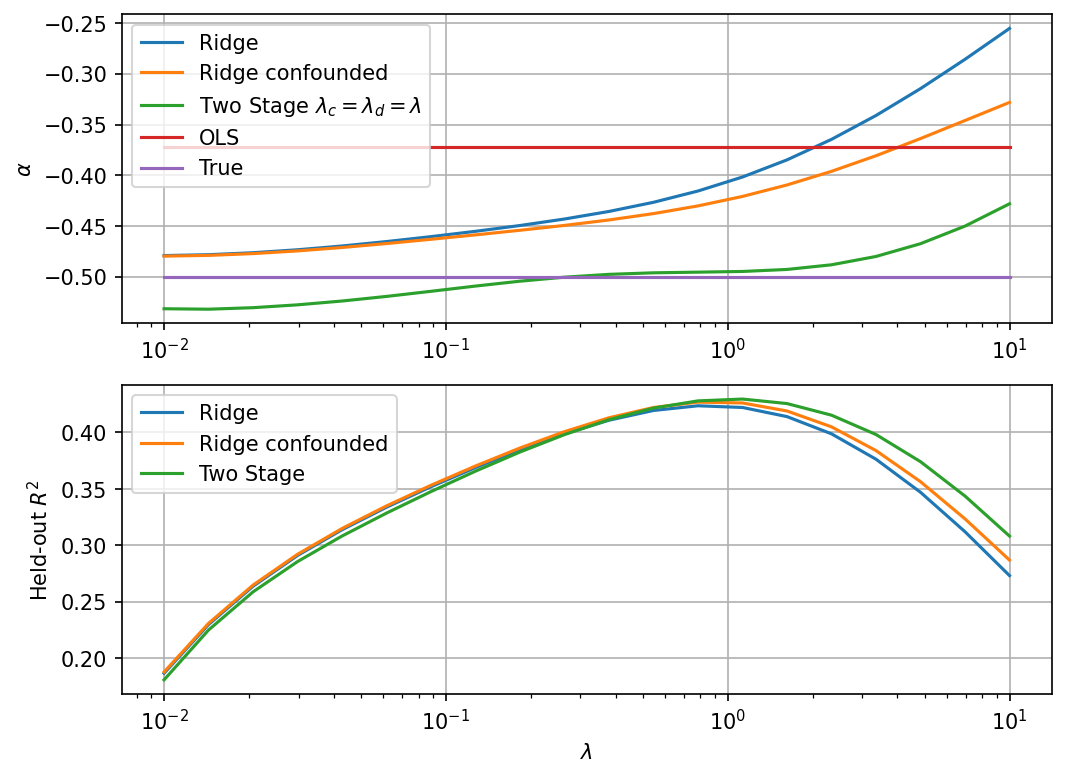

In [3]:
ols = LinearRegression().fit(W, Y)
alpha_ols =  ols.coef_[0]
score_ols = ols.score(W_test, Y_test)

#ts = TwoStageRidge(treatment_index=0, regulariser1=.1, regulariser2=.1).fit(W, Y)
#alpha_ts = ts.alpha_

regularisers = np.logspace(*regulariser_range, 20)
alpha_ridge = np.zeros_like(regularisers)
alpha_conf = np.zeros_like(regularisers)
alpha_ts = np.zeros_like(regularisers)
scores_ridge = np.zeros_like(regularisers)
scores_conf = np.zeros_like(regularisers)
scores_ts = np.zeros_like(regularisers)

for i, regulariser in enumerate(regularisers):
    ts = TwoStageRidge(treatment_index=0, regulariser1=regulariser, regulariser2=regulariser).fit(W, Y)
    alpha_ts[i] = ts.alpha_
    scores_ts[i] = r2_score(Y_test, ts.predict(W_test))  
    
    reg = Ridge(alpha=regulariser).fit(W, Y)    
    alpha_ridge[i] = reg.coef_[0]
    scores_ridge[i] = r2_score(Y_test, reg.predict(W_test))
    
    Wint = np.hstack((W, np.ones((N_train, 1))))
    Wint_test= np.hstack((W_test, np.ones((N_test, 1)))) 
    reg = np.ones(Wint.shape[1]) * regulariser
    reg[0] = 0.
    reg_conf_weights = ridge_weights(Wint, Y, gamma=reg)
    alpha_conf[i] = reg_conf_weights[0]
    scores_conf[i] = r2_score(Y_test, Wint_test @ reg_conf_weights)

print(f"R^2 OLS = {score_ols:.4f}")
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), dpi=150)

ax1.semilogx(regularisers, alpha_ridge, label="Ridge")
ax1.semilogx(regularisers, alpha_conf, label="Ridge confounded")
ax1.semilogx(regularisers, alpha_ts, label="Two Stage $\\lambda_c = \\lambda_d = \\lambda$")
ax1.semilogx([regularisers[0], regularisers[-1]], [alpha_ols, alpha_ols], label="OLS")
ax1.semilogx([regularisers[0], regularisers[-1]], [alpha, alpha], label="True")
ax1.set_ylabel("$\\alpha$")
ax1.grid()
ax1.legend()

ax2.semilogx(regularisers, scores_ridge, label="Ridge")
ax2.semilogx(regularisers, scores_conf, label="Ridge confounded")
ax2.semilogx(regularisers, scores_ts, label="Two Stage")
ax2.grid()
ax2.set_ylabel("Held-out $R^2$")
ax2.set_xlabel("$\\lambda$")
ax2.legend()

plt.show()

# Two-stage test

## Vary $\lambda_d$

\begin{align}
\mathcal{L}_Z &= \frac{1}{N} \sum^N_{i=1} \|Z_i - X_i \beta_c \|^2_2 + \lambda_c \|\beta_c\|_2^2 \\
\mathcal{L}_Y &= \frac{1}{N} \sum^N_{i=1} \|Y_i - [\alpha(Z_i - X_i \beta_c) + X_i \beta_d] \|^2_2 + \lambda \|\beta_d\|_2^2
\end{align}


<img src="../images/two_stage_dag.png" width="50%" />

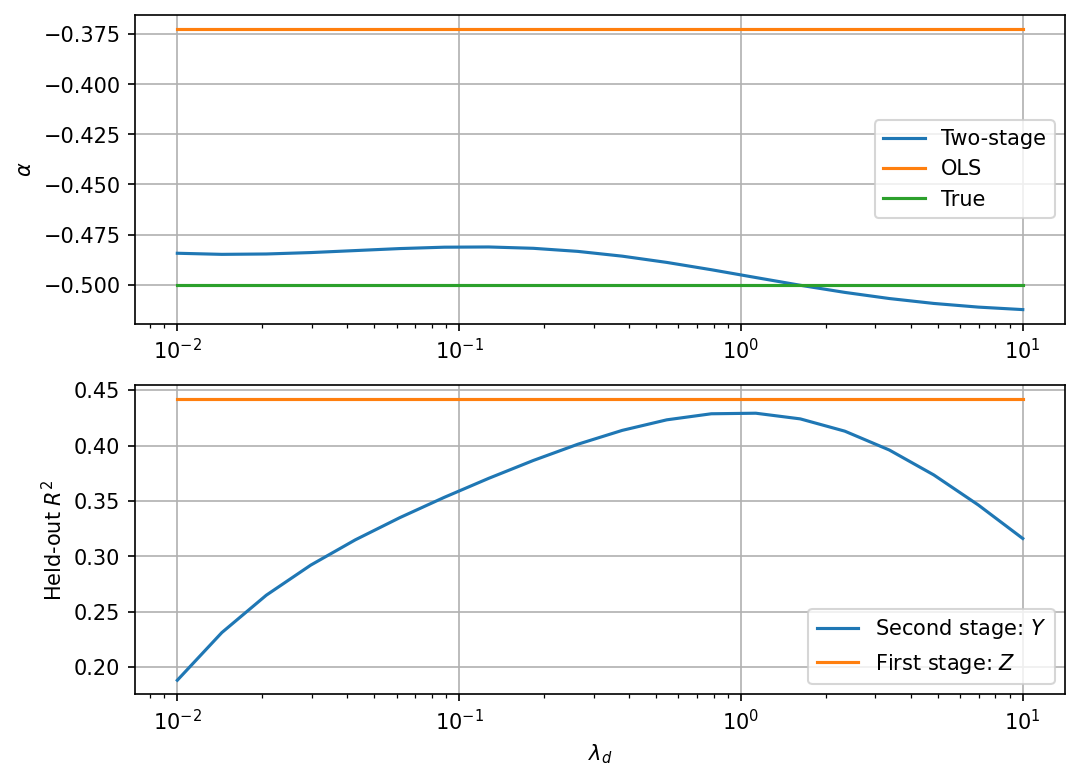

In [4]:
#regularisers = np.logspace(*regulariser_range, 20)
alpha_ts_d = np.zeros_like(regularisers)
y_scores = np.zeros_like(regularisers)
z_scores = np.zeros_like(regularisers)


for i, regulariser in enumerate(regularisers):
    ts_d = TwoStageRidge(treatment_index=0, regulariser1=1., regulariser2=regulariser).fit(W, Y)
    alpha_ts_d[i] = ts_d.alpha_
    y_scores[i] = r2_score(Y_test, ts_d.predict(W_test))
    z_scores[i] = ts_d.score_stage1(W_test)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), dpi=150)
ax1.semilogx(regularisers, alpha_ts_d, label="Two-stage")
ax1.semilogx([regularisers[0], regularisers[-1]], [alpha_ols, alpha_ols], label="OLS")
ax1.semilogx([regularisers[0], regularisers[-1]], [alpha, alpha], label="True")
ax1.set_ylabel("$\\alpha$")
ax1.grid()
ax1.legend()
ax2.semilogx(regularisers, y_scores, label="Second stage: $Y$")
ax2.semilogx(regularisers, z_scores, label="First stage: $Z$")
ax2.grid()
ax2.legend()
ax2.set_ylabel("Held-out $R^2$")
ax2.set_xlabel("$\\lambda_d$")
plt.show()

## Vary $\lambda_c$

\begin{align}
\mathcal{L}_Z &= \frac{1}{N} \sum^N_{i=1} \|Z_i - X_i \beta_c \|^2_2 + \lambda_c \|\beta_c\|_2^2 \\
\mathcal{L}_Y &= \frac{1}{N} \sum^N_{i=1} \|Y_i - [\alpha(Z_i - X_i \beta_c) + X_i \beta_d] \|^2_2 + \lambda \|\beta_d\|_2^2
\end{align}

<img src="../images/two_stage_dag.png" width="50%" />

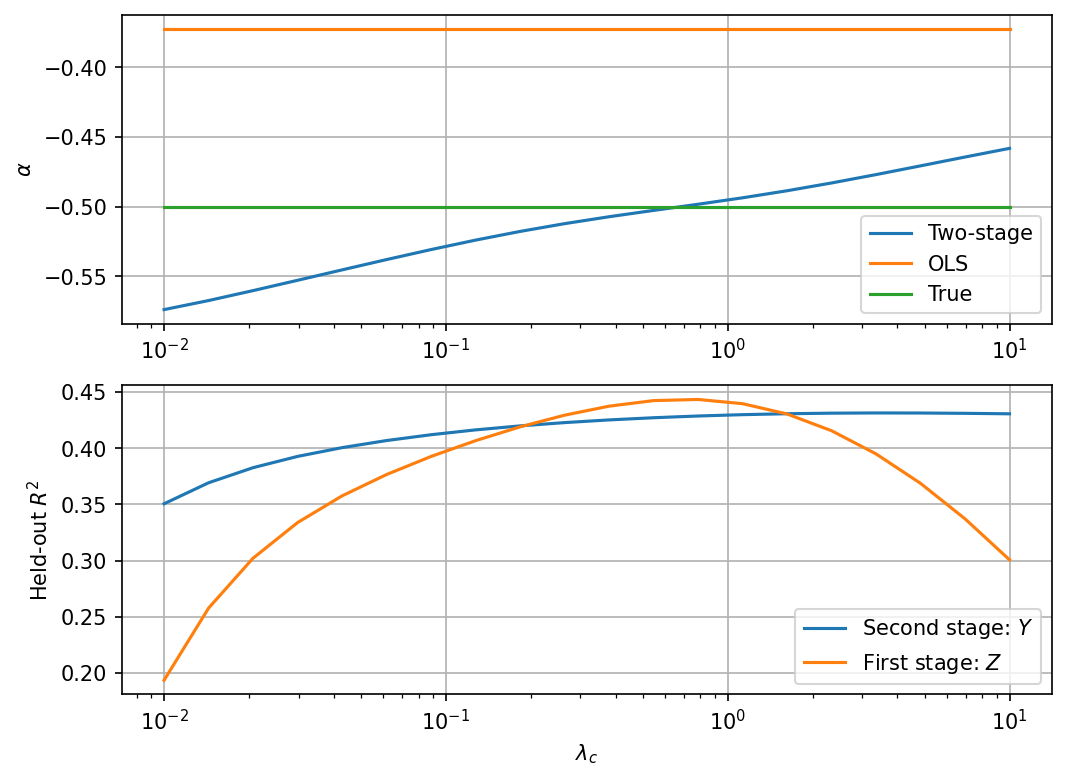

In [5]:
#regularisers = np.logspace(-2, 3, 50)
alpha_ts_c = np.zeros_like(regularisers)
y_scores = np.zeros_like(regularisers)
z_scores = np.zeros_like(regularisers)


for i, regulariser in enumerate(regularisers):
    ts_c = TwoStageRidge(treatment_index=0, regulariser1=regulariser, regulariser2=1.).fit(W, Y)
    alpha_ts_c[i] = ts_c.alpha_
    y_scores[i] = r2_score(Y_test, ts_c.predict(W_test))
    z_scores[i] = ts_c.score_stage1(W_test)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), dpi=150)
ax1.semilogx(regularisers, alpha_ts_c, label="Two-stage")
ax1.semilogx([regularisers[0], regularisers[-1]], [alpha_ols, alpha_ols], label="OLS")
ax1.semilogx([regularisers[0], regularisers[-1]], [alpha, alpha], label="True")
ax1.set_ylabel("$\\alpha$")
ax1.grid()
ax1.legend()
ax2.semilogx(regularisers, y_scores, label="Second stage: $Y$")
ax2.semilogx(regularisers, z_scores, label="First stage: $Z$")
ax2.grid()
ax2.legend()
ax2.set_ylabel("Held-out $R^2$")
ax2.set_xlabel("$\\lambda_c$")
plt.show()